In [3]:
import numpy as np
import tensorflow as tf
from sklearn import datasets
from sklearn.cross_validation import train_test_split
import pylab as pl
from IPython import display
import pandas as pd
import sys
%matplotlib inline

In [4]:
n_input = 13 
seq_max_len = 200 # Sequence max lengths
n_classes = 2 # MNIST total classes (0-9 digits)
    
def getDesired(df):
    group = df.groupby(['SrcAddr'])
    df_X = []
    df_Y = pd.DataFrame(columns=['0','1'])
    df_len = []

    for i in group:
        temp =  i[1].copy()
        temp['Label']
        if sum(temp.Label)/len(temp) == 0:
            df_Y = df_Y.append(pd.Series({'0':1, '1':0}),ignore_index=True)
        else:
            df_Y = df_Y.append(pd.Series({'0':0, '1':1}),ignore_index=True)
        df_len.append(len(temp))
        del temp['Label'], temp['SrcAddr']
        A = temp.as_matrix()
        #A = A.reshape(-1,len(A)*n_input)
        B = np.pad(A, ((0,(seq_max_len-len(A))), (0,0)), mode= 'constant')
        #np.pad(x, ((0,10), (0,0)), mode='constant', constant_values=42)
        B = B.reshape(-1,seq_max_len, n_input)
        df_X.append(B)
    df_X = np.asarray(df_X)
    df_X = df_X.reshape(-1,seq_max_len,n_input)
    df_Y = df_Y.as_matrix()
    df_len = np.asarray(df_len)
    df_len = df_len.reshape(-1,)
    return df_X,df_Y, df_len

In [5]:
dfTrain = pd.read_csv("/home/ankit/Desktop/MTP/working_directory/Binenetflow/ISCX_Botnet-Training.biargus.binetflow")
#df1 = pd.read_csv("/home/ankit/Desktop/MTP/working_directory/Binenetflow/ISCX_Botnet-Testing.biargus.binenetflow")
#dfTrain = pd.DataFrame.append(dfTrain,df1)
#Add Label to flows
dfTrain['Label'] = pd.Series(np.zeros(len(dfTrain['Dur'])), index=dfTrain.index)
malicious_ips = "192.168.2.112 131.202.243.84 192.168.5.122 198.164.30.2 192.168.2.110 192.168.4.118 192.168.2.113 192.168.1.103 192.168.4.120 192.168.2.112 192.168.2.109 192.168.2.105 147.32.84.180 147.32.84.170 147.32.84.150 147.32.84.140 147.32.84.130 147.32.84.160 10.0.2.15 192.168.106.141 192.168.106.131 172.16.253.130 172.16.253.131 172.16.253.129 172.16.253.240 74.78.117.238 158.65.110.24 192.168.3.35 192.168.3.25 192.168.3.65 172.29.0.116 172.29.0.109 172.16.253.132 192.168.248.165 10.37.130.4"
malicious_ips = malicious_ips.split()

for i in malicious_ips:
    dfTrain.loc[dfTrain["SrcAddr"] == i,"Label"] = 1

dfsTrain = pd.DataFrame()
dfsTrain['SrcAddr'] = dfTrain['SrcAddr']
dfsTrain['Dur'] = dfTrain['Dur']
dfsTrain['Label'] = dfTrain['Label']
#dfsTrain['Sport'] = dfTrain['Sport']
#dfsTrain['Dport'] = dfTrain['Dport']

dfsTrain['SrcBytes'] = dfTrain['SrcBytes']
dfsTrain['TotBytes'] = dfTrain['TotBytes']
dfsTrain['TotPkts'] = dfTrain['TotPkts']
dfsTrain['sTos'] = dfTrain['sTos']
dfsTrain['dTos'] = dfTrain['dTos']
# dfsTrain['sTtl'] = dfTrain['sTtl']
# dfsTrain['dTtl'] = df/Train['dTtl']
# dfsTrain['sHops'] = dfTrain['sHops']
# dfsTrain['dHops'] = dfTrain['dHops']
#Dir State
temp = pd.get_dummies(dfTrain.Dir)
print temp.columns
#del temp['  <-']
dfsTrain = pd.concat([dfsTrain,temp],axis=1)

temp = pd.get_dummies(dfTrain.Proto)
dfsTrain['tcp'] = temp.tcp
dfsTrain['udp'] = temp.udp
del dfTrain
dfsTrain = dfsTrain.convert_objects(convert_numeric=True)
dfsTrain = dfsTrain.fillna(0)
#trainX = dfsTrain.copy()
# trainY = pd.get_dummies(dfsTrain.Label)
# trainY = trainY.as_matrix()
# del trainX['Label']
# trainX = trainX.as_matrix()
# trainX = trainX.reshape(-1,seq_max_len,n_input)
# print trainX.shape
# print trainY.shape

/home/ankit/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index([u'   ->', u'   ?>', u'  <->', u'  <?>', u'  who'], dtype='object')


/home/ankit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:38: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [6]:
df = dfsTrain
total_batch = int(len(df)/seq_max_len)
# Loop over all batches
X = np.empty(shape=(0,seq_max_len,n_input))
Y = np.empty(shape=(0,2))
L = np.empty(shape=(0,))
for i in range(total_batch):
    n = min(seq_max_len, len(df)-i*seq_max_len)
    batch_x, batch_y, batch_len = getDesired(df[i*seq_max_len:i*seq_max_len+n])
    X = np.concatenate((X, batch_x))
    Y = np.concatenate((Y, batch_y))
    L = np.concatenate((L, batch_len))

trainX = X
trainY = Y
trainL = L
print trainX.shape
print trainY.shape
print trainL.shape

(14757, 200, 13)
(14757, 2)
(14757,)


In [7]:
dfTest = pd.read_csv("/home/ankit/Desktop/MTP/working_directory/Binenetflow/ISCX_Botnet-Testing.biargus.binenetflow")
#Add Label to flows
dfTest['Label'] = pd.Series(np.zeros(len(dfTest['Dur'])), index=dfTest.index)
malicious_ips = "192.168.2.112 131.202.243.84 192.168.5.122 198.164.30.2 192.168.2.110 192.168.4.118 192.168.2.113 192.168.1.103 192.168.4.120 192.168.2.112 192.168.2.109 192.168.2.105 147.32.84.180 147.32.84.170 147.32.84.150 147.32.84.140 147.32.84.130 147.32.84.160 10.0.2.15 192.168.106.141 192.168.106.131 172.16.253.130 172.16.253.131 172.16.253.129 172.16.253.240 74.78.117.238 158.65.110.24 192.168.3.35 192.168.3.25 192.168.3.65 172.29.0.116 172.29.0.109 172.16.253.132 192.168.248.165 10.37.130.4"
malicious_ips = malicious_ips.split()

for i in malicious_ips:
    dfTest.loc[dfTest["SrcAddr"] == i,"Label"] = 1

dfsTest = pd.DataFrame()
dfsTest['SrcAddr'] = dfTest['SrcAddr']
dfsTest['Dur'] = dfTest['Dur']
dfsTest['Label'] = dfTest['Label']
#dfsTest['Sport'] = dfTest['Sport']
#dfsTest['Dport'] = dfTest['Dport']
dfsTest['SrcBytes'] = dfTest['SrcBytes']
dfsTest['TotBytes'] = dfTest['TotBytes']
dfsTest['TotPkts'] = dfTest['TotPkts']
dfsTest['sTos'] = dfTest['sTos']
dfsTest['dTos'] = dfTest['dTos']
# dfsTest['sTtl'] = dfTest['sTtl']
# dfsTest['dTtl'] = dfTest['dTtl']
#dfsTest['sHops'] = dfTest['sHops']
#dfsTest['dHops'] = dfTest['dHops']
temp = pd.get_dummies(dfTest.Dir)
del temp['  <-']
print temp.columns
dfsTest = pd.concat([dfsTest,temp],axis=1)

temp = pd.get_dummies(dfTest.Proto)
dfsTest['tcp'] = temp.tcp
dfsTest['udp'] = temp.udp
del dfTest
dfsTest = dfsTest.convert_objects(convert_numeric=True)

dfsTest = dfsTest.fillna(0)

Index([u'   ->', u'   ?>', u'  <->', u'  <?>', u'  who'], dtype='object')


/home/ankit/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:34: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [8]:
df = dfsTest
total_batch = int(len(df)/seq_max_len)
# Loop over all batches
X = np.empty(shape=(0,seq_max_len,n_input))
Y = np.empty(shape=(0,2))
L = np.empty(shape=(0,))
for i in range(total_batch):
    n = min(seq_max_len, len(df)-i*seq_max_len)
    batch_x, batch_y, batch_len = getDesired(df[i*seq_max_len:i*seq_max_len+n])
    X = np.concatenate((X, batch_x))
    Y = np.concatenate((Y, batch_y))
    L = np.concatenate((L, batch_len))

testX = X
testY = Y
testL = L
print testX.shape
print testY.shape
print testL.shape

(8706, 200, 13)
(8706, 2)
(8706,)


In [ ]:
# dfsTrain = dfTrain.copy()#.filter(['SrcAddr','Dur','sTos','dTos','TotPkts','SrcPkts','DstPkts',
# #                           'TotBytes','SrcBytes','DstBytes','TotAppByte','SAppBytes',
# #                           'arp', 'icmp', 'igmp', 'ipv6-icmp','rtcp','rtp','tcp','udp',
# #                           'udt','   ->','   ?>','  <->','  <?>', '  who', 'Label'], axis=1)
# dfsTest = dfTest.copy()#.filter(['SrcAddr','Dur','sTos','dTos','TotPkts','SrcPkts','DstPkts',
# #                           'TotBytes','SrcBytes','DstBytes','TotAppByte','SAppBytes',
# #                           'arp', 'icmp', 'igmp', 'ipv6-icmp','rtcp','rtp','tcp','udp',
# #                           'udt','   ->','   ?>','  <->','  <?>', '  who','Label'], axis=1)

# df = dfTrain
# window_size = 100
# total_batch = int(len(df)/window_size)
# trainD = pd.DataFrame()
# # Loop over all batches
# for i in range(total_batch):
#     n = min(window_size, len(df)-i*window_size)
#     df_win = df[i*window_size:i*window_size+n]
#     group = df_win.groupby(['SrcAddr'])
#     train_win = group.Sport.nunique()
#     #train_win.rename(columns={'Sport':'usrc_port'},inplace=True)
#     train_win = pd.DataFrame(train_win)
#     train_win['udest_ip'] = group.DstAddr.nunique()
#     train_win['udest_port'] = group.Dport.nunique()
#     train_win['netflows'] = group.Dport.count()
#     train_win['bytes'] = group.TotBytes.sum()
#     train_win['packets'] = group.TotPkts.sum()
#     train_win['Label'] = (group.Label.sum()*1.0/group.Dport.count())> 0
#     trainD = pd.DataFrame.append(trainD,train_win)

# del dfsTrain['SrcAddr']
# trainY = pd.get_dummies(dfsTrain.Label)
# trainY = trainY.as_matrix()
# #trainY = dfTrain.Label
# del dfsTrain['Label']
# trainX = dfsTrain.as_matrix()

# del dfsTest['SrcAddr']
# testY = pd.get_dummies(dfsTest.Label)
# testY = testY.as_matrix()
# #testY = dfTest.Label
# del dfsTest['Label']
# testX = dfsTest.as_matrix()

In [10]:
graph = tf.Graph()
with graph.as_default():
    # Parameters
    learning_rate = 0.0001
    training_iters = 20
    batch_size = 100
    display_step = 1

    # Network Parameters
    n_input = 13 
    seq_max_len = 200 # Sequence max lengths
    n_hidden = 100 # hidden layer num of features
    n_classes = 2 # MNIST total classes (0-9 digits)

    # tf Graph input
    x = tf.placeholder("float", [None, seq_max_len, n_input])
    y = tf.placeholder("float", [None, n_classes])
    seqlen = tf.placeholder(tf.int32, [None])
    
    # Define weights
    weights = {
        # Hidden layer weights => 2*n_hidden because of forward + backward cells
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes]))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }


    def RNN(x, weights, biases, seqlen):

        # Prepare data shape to match `bidirectional_rnn` function requirements
        # Current data input shape: (batch_size, n_steps, n_input)
        # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

        # Permuting batch_size and n_steps
        x = tf.transpose(x, [1, 0, 2])
        # Reshape to (n_steps*batch_size, n_input)
        x = tf.reshape(x, [-1, n_input])
        # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
        x = tf.split(0, seq_max_len, x)

        # Define lstm cell with tensorflow
        lstm_cell = tf.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0)
        #initial_state = lstm_cell.zero_state(batch_size, tf.float32)
        # Get lstm cell output
        outputs, _ = tf.nn.rnn(lstm_cell, x, dtype=tf.float32, sequence_length=seqlen)
        # Linear activation, using rnn inner loop last output
        return tf.matmul(outputs[-1], weights['out']) + biases['out']

    pred = RNN(x, weights, biases,seqlen)

    # Define loss and optimizer
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Evaluate model
    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [ ]:
# np.save('trainX.npy', X)
# np.save('trainY.npy', Y)
# np.save('trainL.npy', L)
# trainX = np.load('/home/ankit/Desktop/MTP/working_directory/trainX.npy')
# trainY = np.load('/home/ankit/Desktop/MTP/working_directory/trainY.npy')
# trainL = np.load('/home/ankit/Desktop/MTP/working_directory/trainL.npy')
# testX = np.load('/home/ankit/Desktop/MTP/working_directory/testX.npy')
# testY = np.load('/home/ankit/Desktop/MTP/working_directory/testY.npy')
# testL = np.load('/home/ankit/Desktop/MTP/working_directory/testL.npy')

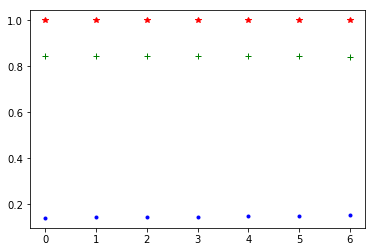

Iteration: 6 Loss: 0.152592 Train Accuracy: 1.0 Test Accuracy: 0.842063

KeyboardInterrupt: 

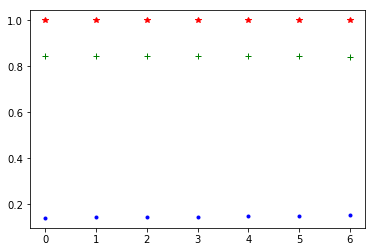

In [11]:
# Launch the graph
with tf.Session(graph=graph) as sess:
    # Initializing the variables
    init = tf.initialize_all_variables()
    
    sess.run(init)
    # Keep training until reach max iterations
    for iters in range(training_iters):
        total_batch = int(len(trainX)/batch_size)
        # Loop over all batches
        for i in range(total_batch):
            n = min(batch_size, len(trainX)-i*batch_size)
            batch_x= trainX[i*batch_size:i*batch_size+n]
            batch_y =trainY[i*batch_size:i*batch_size+n]
            batch_len =trainL[i*batch_size:i*batch_size+n]
            # Reshape data to get 28 seq of 28 elements
            #batch_x = batch_x.reshape((batch_size, seq_max_len, n_input))
            # Run optimization op (backprop)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, seqlen: batch_len})
        if iters % display_step == 0:
            # Calculate batch accuracy
            Train_accuracy = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y, seqlen: batch_len})
            # Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, seqlen: batch_len})
            #testX = testX.reshape(-1,seq_max_len,n_input)
            Test_accuracy=str(sess.run(accuracy,feed_dict={x:testX, y:testY, seqlen: testL}))    
            pl.plot([iters],loss,'b.',)
            pl.plot([iters],Train_accuracy,'r*',)
            pl.plot([iters],Test_accuracy,'g+')
            display.clear_output(wait=True)
            display.display(pl.gcf())   
            sys.stdout.flush()
            print("\rIteration: %s Loss: %s Train Accuracy: %s Test Accuracy: %s"%(iters,loss,Train_accuracy,Test_accuracy)),
            sys.stdout.flush()
    print("Optimization Finished!")
    # Calculate accuracy for 128 mnist test images
    print("Testing Accuracy:", \
    sess.run(accuracy, feed_dict={x:testX, y:testY, seqlen: testL}))
    print("Training Accuracy:", \
    sess.run(accuracy, feed_dict={x:trainX, y:trainY, seqlen: trainL}))
    prediction=tf.argmax(pred,1)
    out =  prediction.eval(feed_dict={x: testX})

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(out, dfTest['Label']) #0 = normal

In [28]:
trainY.sum(axis=0)

array([ 10876.,   3881.])